# Meten hoe snel handdoeken drogen met een warmte-camera. 
Hoe snel droogt een sneldrogende handdoek? Is dat sneller dan een normale katoenen handdoek? Kan je dat meten? Dat was de vraag die de redactie van TV-programma Kassa bij mij neerlegde.

Hoewel mijn eerste gedachte was om het gewicht van een handdoek te meten terwijl die aan het drogen was, verwierp ik dat idee redelijk snel: als een handdoek in de wind droogt dan zijn de trek krachten van de wind veel groter dan het (verschil in) zwaartekracht door het verdampen van water. 

Ik realiseerde me dat door het verdampen van water een nog natte handdoek kouder zal zijn dan een zelfde handdoek die droog is. Als je een natte handdoek naast een zelfde, maar droge, handdoek hangt dan ervaren beide handdoeken dezelfde wind en temperatuur van de buitenwereld. Het temperatuur verschil tussen de twee wordt dan volledig bepaald door de verdamping van water uit de natte handdoek. Wanneer de natte handdoek dezelfde temperatuur aanneemt als de droge handdoek, is er geen water meer om te verdampen en is de natte handdoek (dus) droog.

De makkelijkste manier om een handdoek zijn temperatuur te meten zonder deze te beinvloeden is om er met een warmte-camera (ook wel "infra rood camera) naar te kijken. Dus dat gaan we doen. In dit notebook beschrijf ik de natuurkundige achtergrond, de opzet van ons experiment en analyseer ik de resultaten. Voor volledigheid hebben we dit experiment 4 keer gedaan. De overige drie notebooks in dit github repository beschrijven de overige drie experimenten, waarbij de uitleg bij experiment 2 in het Engels is en bij experimenten 3 en 4 is de uitleg minimaal omdat deze al hier vermeld staat.

In [1]:
# opencv moet geinstalleerd zijn om met video te kunnen werken. 
# Uncomment de regel hieronder als opencv nog niet geinstalleerd is

#!pip install opencv-python

In [2]:
#importeren van libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import cv2
import pandas as pd
from IPython.display import Video

## De Natuurkunde
Elk willekeurig object absorbeerd straling vanuit de omgeving en zend zelf straling uit in het infra-rood bereik van het spectrum. Wij kennen deze straling als "warmte-straling". The hoeveelheid uitgezonden infra-rood wordt beschreven door de Boltzman stralingswet:

$$\begin{equation}\Phi_{o} = \sigma T_{s}^{4}\end{equation}$$

Hier is $\Phi_{o}$ (in Watts per vierkante meter) de uitgezonden straling, $\sigma$ is de Stefan-Boltzman constant en $T_{s}$ is de (oppervlakte) temperatuur an het object (in graden Kelvin!). In object in een perfect vacuum dat een hoeveel inkomende straling van $\Phi_{i}$ opvangt zal dan een evenwichtstemperatuur bereiken waarbij inkomende en uitgezonden straling aan elkaar gelijk zijn:

$$
\begin{eqnarray}
\Phi_{i} &=& \Phi_{o} \\
\Phi_{i} &=& \sigma T_{s}^{4} \\
T_{s} &=& \sqrt[4]{\frac{\Phi_{i}}{\sigma}}
\end{eqnarray}
$$

Echter: de handdoeken hangen niet in een vacuum: er is ook uitwisseling van warmte met de lucht om de handdoeken heen. De wind blaast koele (of warme) lucht langs de handdoek. De energie-overdracht, door natuurkundige energie-flux genoemd, die daarmee samenhangt wordt beschreven door Newton zijn koelingswet:

$$ 
\Phi_c = h\left(T_{s} - T_{a}\right)
$$

waar $T_{a}$ de temperatuur van de lucht is en $h$ is de "hitte overdrachts coefficient". Deze hangt af van het materiaal, de vorm en nog veel meer dingen. Als we dit toevoegen hebben we:

$$
\begin{eqnarray}
\Phi_{i} &=& \Phi_{o} + \Phi_{c} \\
\Phi_{i} &=& \sigma T_{s}^{4} + h\left(T_{s} - T_{a}\right)\\
\end{eqnarray}
$$

Ten slotte, wanneer we een handdoek natmaken wordt een deel van de binnenkomende energie gebruikt om water te verdampen in plaats van de handdoek op te warmen. De snelheid waarmee water verdampt en dus de hoeveelheid energie die daarvoor gebruikt wordt hangt van heel veel dingen af, maar laten we voor nu deze energie-flux $\Phi_{e}$ noemen.

$$
\begin{eqnarray}
\Phi_{i} &=& \Phi_{o} + \Phi_{c} +\Phi_{e}\\
\Phi_{i} &=& \sigma T_{s}^{4} + h\left(T_{s} - T_{a}\right)+\Phi_{e}\\
\end{eqnarray}
$$

Dit is lastig (maar niet onmogelijk) om analytisch wiskundig op te lossen voor $T_{s}$. Om gevoel te krijgen voor wat er gebeurd is het handig om wat aannames te maken. Ten eerste, stel dat het temperatuur verschil tussen een natte en een droge handdoek klein is ten opzichte van het verschil tussen de handdoek en de lucht die erlangs stroomt. Dan kunnen we stellen dat: $h\left(T_{s} - T_{a}\right)$ constant is. Als we verder aannemen dat $\Phi_{e}$ constant is terwijl een handdoek droogt en gelijk aan nul is wanneer een handdoek droog is, dan kunnen we met $T_{w}$ als temperatuur voor de natte handdoek en $T_{d}$ voor de droge handdoek stellen dat:

$$
\begin{eqnarray}
T_{w}^{4} &=& {\frac{\Phi_{i} - \Phi_{c} -\Phi_{e}}{\sigma}}\\
T_{d}^{4} &=& {\frac{\Phi_{i} - \Phi_{c}}{\sigma}} \\
T_{w} &=& \sqrt[4]{{T_{d}^{4} - \frac{\Phi_{e}}{\sigma}}}\\
\end{eqnarray}
$$

Hiermee kunnen we een ruwe schatting maken hoeveel kouder een natte handdoek gaat zijn dan een droge handdoek, door naar onze eigen ervaringen te kijken. Stel een handdoek van precies één vierkante meter heeft na afdrogen en uitknijpen nog 100 gram aan water in zich opgenomen. Hoe lang duurt het voordat deze handdoek droog is als we deze buiten hangen op een dag dat het buiten 30 graden celcius is? Bij 30 graden celcius is de hoeveelheid energie nodig om 1 kg water te verdampen gelijk aan 2300 kJ (Dit heet de latente verdampingswarmte en wordt, heel verwarrend, ook vaak met een $h$ aangegeven in formlues). Als we inschatten dat het een uur duurt om de handdoek te laten drogen , dan is de energie-flux $\Phi_{e}$: 

In [3]:
dt = 3600 #tijd
m = 0.1 #mass
A = 1 #area
h = 2300e3 #latent heat of vaporisation
Phi_e = (h * m) / (A * dt) #vaporisation flux in J per second per square meter (or: Watt per square meter)

print('verdampings flux is %.2f Watt per vierkante meter' % (Phi_e))


verdampings flux is 63.89 Watt per vierkante meter


Dit kunnen we gebruiken om een ruwe schatting (met alle onrealistische aannames die we hierboven deden) te geven voor het temperatuur verschil tussen natte en droge handdoeken.

In [6]:
sigma = 5.670374419e-8 #Stefan Boltzman constant
T_d = 273.15 + 25 #25 graden Celcius 

T_w = np.power(np.power(T_d,4) - (Phi_e / sigma),(1/4))

print('Temperatuur van natte handoek is %.1f graden Celcius' % (T_w - 273.15))
print('Temperatuurverschil tussen natte handoek en droge handdoek is %.1f graden Celcius' % (T_d - T_w))

Temperatuur van natte handoek is 13.8 graden Celcius
Temperatuurverschil tussen natte handoek en droge handdoek is 11.2 graden Celcius


## Het experiment

We gaan zes verschillende handdoeken vergelijken. Van elk type handdoek worden twee stukken van 25 bij 25 cm gemaakt, de randen netjes afgenaaid. Aan een tweetal waslijnen die vlak boven elkaar gespannen worden kunnen deze handdoeken zodanig hangen dat hetzelfde merk recht boven elkaar hangt. 

Van elk merk wordt één handdoek natgemaakt met 25 ml water. Dit wordt gedaan door de met een keukenweegschaal (nauwkeurigheid 0.1 g) precies 25g water in een plastic bakje te doen. De handdoek wordt daar dan ingerold zodat het vocht zich gelijkmatig verdeeld en het bakje wordt afgesloten om geen vocht te verliezen aan verdamping voordat de proef begint. 

Wanneer deze zes handdoeken nat gemaakt zijn worden ze opgehangen aan de waslijnen. Er zijn op het Hitteplein van de TU Delft twee waslijnen gespannen vlak boven elkaar. Een droge en de natte handdoek van hetzelfde merk worden boven elkaar opgehangen. 

Een warmtecamera van het merk FLIR uit de T-serie is op 5 meter afstand geplaatst en filmt de gehele waslijn gedurende het gehele experiment. Het beeld van de warmte-camera wordt direct op een aangesloten laptop getoond met de FLIR software. Met behulp van screen-capture software wordt van het totale beeld een video bestand gemaakt dat later geanalyseerd kan worden.

Zie onderstaande foto voor een overzicht van de opstelling.

![De meetopstelling met links in beeld de laptop die het camerabeeld van de warmtecamera vastlegd.](./pictures/measurementSetup.jpeg)

Het experiment is vier keer herhaald met telkens de handdoeken in een verschillende volgorde aan de waslijn. De rest van dit notebook beschrijft de analyse van de video en de resultaten van het eerste experiment. De resultaten van de overige experimenten staan in de overige drie jupyter notebooks in dit github repository. Het tweede notebook bevat documentatie in het engels. Notebooks drie en vier bevatten slecht minimale documentatie.


## Data analyse

### Stap 1: video inladen in python
Ik gebruik de OpenCV library voor python om de video in dit notebook te openen en kunnen bekijken voordat we met de analyse beginnen. (Dit kan niet op github worden bekeken, alleen wanneer je de video-bestanden ook hebt)


In [7]:
#de bestandsnaam van de video met de resultaten. Dit bestand kan helaas niet
#op github gedeeld worden omdat het groter is dan github toestaat.
#Het is echter down te loaden via: dx.doi.org/10.5281/zenodo.8167168

fileName = 'Droogtest ronde 1.mp4'

In [8]:
#om te controleren of we daadwerkelijk de juiste video te pakken hebben
Video(fileName,width=550)

In [9]:
#uit bovenstaande weergave, vind het punt waar de meting daadwerkelijk begint
#in milliseconden
startTime = 1.5 * 60 * 1000 

In [10]:
#een test om te zien of we informatie uit het bestand kunnen halen
v = cv2.VideoCapture(fileName)
w = int(v.get(cv2.CAP_PROP_FRAME_WIDTH))    
h = int(v.get(cv2.CAP_PROP_FRAME_HEIGHT))
v.release()
print('Dimensions:',w,h)

Dimensions: 1898 1200


### Stap 2: isoleer de kleurenbalk uit de video om later temperatuur te kunnen bepalen

Omdat we alleen video gegevens hebben en niet direct temperatuur, ga ik de pixels van de kleurenbalk isoleren om zo van de pixels in het video deel van het scherm de temperatuur af te kunnen lezen. Ik ga een functie schrijven die voor een RGB waarde van een pixel als input kan uitrekenen wat de bijbehorende temperatuur is. 

We moeten er wel rekening mee houden dat ik gedurende het experiment regelmatig de minimum en maximum waarden van de kleurenbalk aanpas om het beeld in orde te houden. Dus we moeten ook weten wanneer in de video ik die minimum en maximum verander en naar welke waarden.

In [11]:
#open het bestand en spoel door naar het begin van het experiment.
v = cv2.VideoCapture(fileName)
while v.get(cv2.CAP_PROP_POS_MSEC) < (startTime):
    v.read()

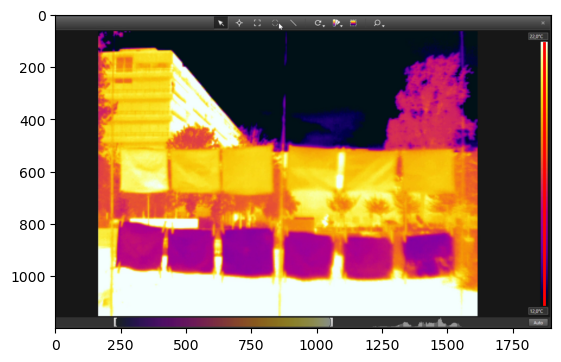

In [12]:
### these coordinaten zijn gevonden door goed naar bovenstaande video te kijken
### en heel vaak te proberen.
colorBarYTop = 108 
colorBarYBottom = 1108
colorbarX = 1870

#haal één beeld uit de video
success, image = v.read()
#converteer naar RGB
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#Maak een plot om te zien of het goed gaat.
#ik voeg een rode lijn toe waar ik denk dat de kleurenbalk zit, als check.
plt.imshow(img)
x = [colorbarX, colorbarX]
y = [colorBarYTop, colorBarYBottom]
plt.plot(x, y, color="red", linewidth=2)

In [13]:
# Dit zijn de minimum en maximum waarden van de kleurenbalk
# en de tijdscodes waarop ik deze verander.
# ook dit is gevonden door goed naar de video te kijken.

colorBarTempMinMax = [[12.0, 22.0],
                      [12.0, 24.0],
                      [12.0, 26.0],
                      [12.0, 28.0],
                      [12.0, 31.0],
                      [12.0, 35.0],
                      [12.0, 30.0]]
colorbarTimeCodes = [(0 * 3600 + 0 * 60 + 0) * 1000,
                     (0 * 3600 +10 * 60 +26) * 1000,
                     (0 * 3600 +12 * 60 +14) * 1000,
                     (0 * 3600 +42 * 60 +54) * 1000,
                     (0 * 3600 +43 * 60 + 4) * 1000,
                     (0 * 3600 +55 * 60 +53) * 1000,
                     (1 * 3600 + 2 * 60 +50) * 1000,
                     (2 * 3600 + 0 * 60 + 0) * 1000,
]

colorBarValues = img[colorBarYTop:colorBarYBottom,colorbarX,:]

colorBarCounter = 0;

#deze functie maakt een kleuren-as tussen de minimum en maximum temperatuur
def getTempAxis(colorBarValues,colorBarTempMinMax):
    return np.linspace(colorBarTempMinMax[1],colorBarTempMinMax[0],len(colorBarValues)) 
#let op de indexen: hoge temperatuur bij lage pixel index!

tempAxis = getTempAxis(colorBarValues,colorBarTempMinMax[colorBarCounter])
colorBarCounter = colorBarCounter + 1


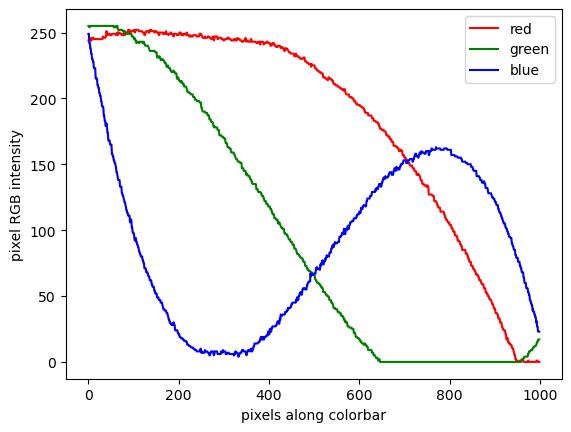

In [14]:
# maak een grafiek van de rood, groen en blauw waarde van de kleurenbalk
# als controle om te zien of ik de juiste locatie in het beeld gekozen heb
plt.plot(colorBarValues[:,0],'r',
         colorBarValues[:,1],'g',
         colorBarValues[:,2],'b')
plt.legend(['red','green','blue'])
plt.xlabel('pixels along colorbar')
plt.ylabel('pixel RGB intensity')
plt.savefig('figures/meting1/kleurenbalk.png', dpi = 300)

In [15]:
#Deze functie geeft de temperatuur waarde van een pixel terug en is 
# dus centraal in de analyse.
    
def getTempFromRGB(targetRGB,colorBarValues, tempAxis):
    obj = np.linalg.norm([256,256,256]) #max value of difference between pixels
    temp = []
    for i in range(len(colorBarValues)):
        objPixel = np.linalg.norm(targetRGB-colorBarValues[i])
        if (objPixel < obj):
            obj = objPixel
            temp = tempAxis[i]
    return temp

### Step 3: identificeer waar in het beeld de handdoeken hangen en bepaal temperatuur per handdoek

Eerst moet ik opzoeken waar in het beeld de verschillende handdoeken hangen. Zodra ik de pixel coordinaten daarvan gevonden heb kan ik per frame van de video de gemiddelde RGB pixelwaarde per handdoek bepalen en met bovenstaande functie dus de gemiddelde temperatuur per handdoek.

Deze stap duurt lang! Om dit niet elke keer opnieuw te hoeven runnen, sla ik de ruwe gevonden temperatuur gegevens op in een pickle-bestand, dat later makkelijk ingeladen kan worden.

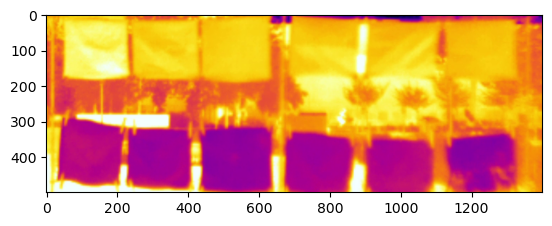

In [16]:
#Beeld het frame af om naar de handdoeken te zoeken
plt.imshow(img[500:1000,200:1600,:])

In [17]:
#Dit zijn de gevonden locaties van de handdoeken. Dit is bepaald door deze cel
# en de cel hieronder herhaaldelijk te runnen en bij te stellen.
towelTopLeftList = [[200+70, 500+40],
                    [200+70, 500+340],
                    [200+270, 500+40],
                    [200+270, 500+340],
                    [200+470, 500+40],
                    [200+470, 500+360],
                    [200+710, 500+40],
                    [200+710, 500+360],
                    [200+940, 500+50],
                    [200+940, 500+370],
                    [200+1160, 500+50],
                    [200+1170, 500+370],
                   ]
towelDescriprion = ['A droog','A nat',
                    'B droog','B nat',
                    'C droog','C nat',
                    'D droog','D nat',
                    'E droog','E nat',
                    'F droog','F nat',
                   ]

towelSize = [100,100]

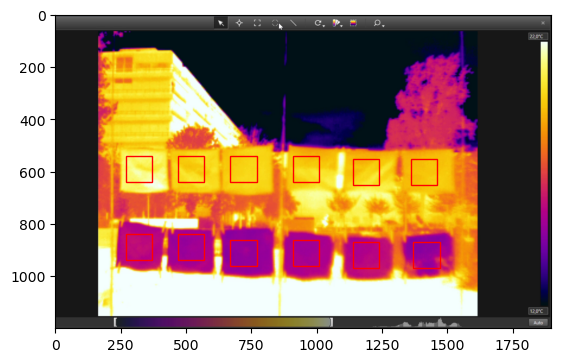

In [18]:
# Laat zien waar de gevonden handdoeken zitten door er een rood vierkant in te tekenen
fig, ax = plt.subplots()
ax.imshow(img)
# maak een vierkant per handdoek:
for towelTopLeft in towelTopLeftList:
    rect = patches.Rectangle(towelTopLeft, towelSize[0],towelSize[1], linewidth=1, edgecolor='r', facecolor='none')
    # voeg vierkant toe aan het figuur (letterlijk: aan de as).
    ax.add_patch(rect)

plt.savefig('figures/meting1/selectiesMeeting1.png',dpi = 300)

In [19]:
#maak lege variabellen en dataframes aan om straks de temperatuur en tijd informatie in op te slaan
tempAllTowels = pd.DataFrame(columns=towelDescriprion)
time = []


In [20]:
#Ga frame voor frame door de hele video, bekijk per frame de gemiddelde 
#RGB pixelwaarde per handdoek en bepaal de temperatuur.

#DEZE CELL DUURT LANG OM TE RUNNEN EN HEEFT DUS DE VIDEO NODIG
# ALS JE ALLEEN MET DE RESULATEN WILT WERKEN, SLA DEZE CELL DAN OVER

while v.isOpened():
    
    #lees het volgende frame als image
    success, image = v.read()
    if success:
        
        #vraag de tijdstap op in milliseconden
        msec = v.get(cv2.CAP_PROP_POS_MSEC)
        
        #Als we sinds het vorige frame de grenzen van de kleurenbalk hebben gewijzigd
        # bepaal dan opnieuw de temperatuur-as
        if (msec > colorbarTimeCodes[colorBarCounter]):
            tempAxis = getTempAxis(colorBarValues,colorBarTempMinMax[colorBarCounter])
            colorBarCounter = colorBarCounter + 1
            
        #Zet het image om naar RGB waarden
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        #loop door de verschillende handdoeken, neem de gemiddelde RGB waarde en bepaal de temperatuur
        temp = []
        for towelTopLeft in towelTopLeftList:
            meanRGBTowel = np.mean(img[towelTopLeft[1]:(towelTopLeft[1]+towelSize[1]),towelTopLeft[0]:(towelTopLeft[0]+towelSize[0])],axis = (0,1))
            temp.append(getTempFromRGB(meanRGBTowel,colorBarValues, tempAxis))

        #voeg alle gevonden temperaturen toe aan het dataframe op de juiste tijdstap
        tempAllTowels.loc[msec/(60 * 1000)] = temp
        
        #om de voortgang bij te houden: print onder deze cell
        #hoever de berekening is (in minuten van de lengte van de video)
        print(msec/(60 * 1000),end = '\r')
    else:
        break


In [21]:
#Sla het dataframe op als een pickle, zodat bovenstaande niet elke keer
#opnieuw gerund hoeft te worden.

#als je de video niet wilt analyseren, comment deze regel dan uit
tempAllTowels.to_pickle("data/rawMeeting1")

In [22]:
#sluit de video af
v.release()

### Stap 4: analyseer tempertuur gegevens om te bepalen hoe snel de handdoeken drogen

Eerst zal ik de gegevens een beetje moeten filteren: mensen die door het beeld lopen, het aangaan van de screensaver, dat soort dingen verstoren de meting. Ik plot eerst de ruwe data voor één type handdoek, zowel de natte als droge handdoek.

In [23]:
#Als je niet de video geanalyseerd heb kan je met deze cell de pickle file inladen
#van mijn analyse. Uncomment dan onderstaande regel

#tempAllTowels = pd.read_pickle("data/rawMeeting1") 

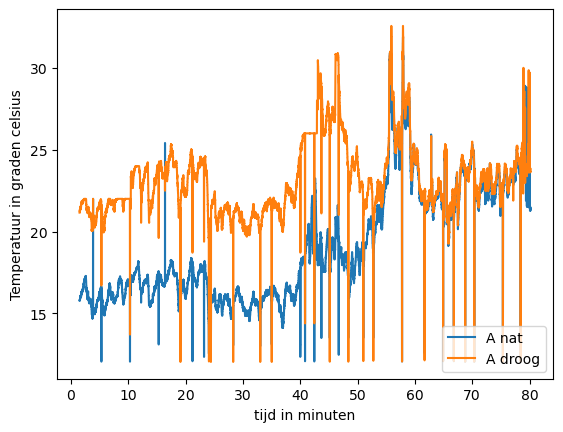

In [24]:
#Maak een plot van de ruwe gegevens voor één type handdoek.
tempAllTowels.plot(y=['A nat', 'A droog'], 
                   xlabel = 'tijd in minuten', 
                   ylabel = 'Temperatuur in graden celsius').legend(['A nat','A droog'],loc = 'lower right')


Het is duidelijk dat er 'fouten' in de data zitten. De gekke rechte lijnen komen van die beelden in de video wanneer mensen door het beeld lopen of wanneer de schermbeveiliging aan gaat. Dat kunnen we eruit filteren door val elke 10 seconden aan gegevens de mediaan (niet het gemiddelde!) te nemen. Dat geeft het volgende resultaat:

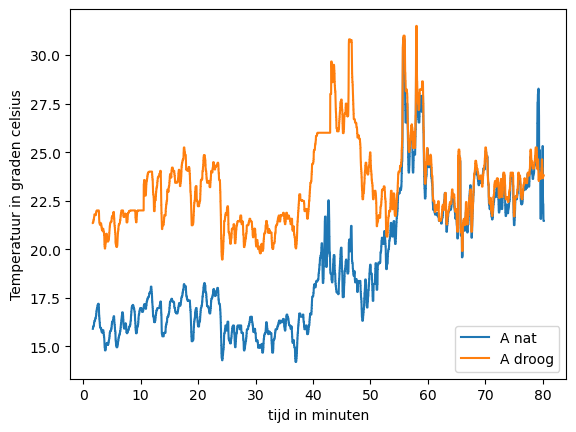

In [25]:
tempAllTowels.rolling(30*10).median().plot(y=['A nat', 'A droog'], 
                   xlabel = 'tijd in minuten', 
                   ylabel = 'Temperatuur in graden celsius').legend(['A nat','A droog'],loc = 'lower right')


Dat is al stukken beter. Wel zien we dat de temperatuur nog flink heen en weer gaat. Wel zien we dat de twee handdoeken tegelijk warmer en kouder worden. Dit komt door bijvoorbeeld een wolk voor de zon, een windvlaag, etc. Als natuurkundige is het heel mooi om te zien dat je die effecten zo duidelijk in de meetgegevens terug ziet. Maar om te bepalen wanneer de handdoeken droog zijn is het beter om te middelen. Ik middel daarom over de laatste minuut. Dit heet een lopend gemiddelde. 

In [26]:
#omdat dit de gefilterde gegevens zijn waar we verder
# mee gaan werken zet ik deze in een nieuw dataframe
tempAllTowelsFiltered = tempAllTowels.rolling(30*10).median().rolling(30*60).mean()


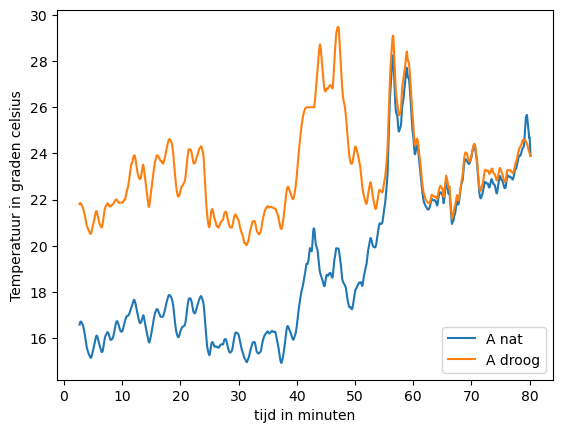

In [27]:
tempAllTowelsFiltered.plot(y=['A nat', 'A droog'], 
                   xlabel = 'tijd in minuten', 
                   ylabel = 'Temperatuur in graden celsius').legend(['A nat','A droog'],loc = 'lower right')
plt.savefig('figures/meting1/handdoekenRuwResultaatmeeting1.png', dpi = 300)

Dat ziet er mooi uit! Nu bereken ik voor elke handdoek het verschil tussen de natte en droge handdoek, voor elke tijdstap van de video. Ik introduceer hieronder labels A tot en met F: dat zijn de labels die we tijdens het experiment gebruikt hadden. Voor volledige eerlijkheid wist ik niet welke handdoek van welk merk was. 

Pas na het experiment is mij verteld door de redactie van Kasse welke handdoek van welk merk is. Dat staat in de tweede cell hieronder. 

In [28]:
tempAllTowelsFiltered['A'] = tempAllTowelsFiltered['A droog'] - tempAllTowelsFiltered['A nat'];
tempAllTowelsFiltered['B'] = tempAllTowelsFiltered['B droog'] - tempAllTowelsFiltered['B nat'];
tempAllTowelsFiltered['C'] = tempAllTowelsFiltered['C droog'] - tempAllTowelsFiltered['C nat'];
tempAllTowelsFiltered['D'] = tempAllTowelsFiltered['D droog'] - tempAllTowelsFiltered['D nat'];
tempAllTowelsFiltered['E'] = tempAllTowelsFiltered['E droog'] - tempAllTowelsFiltered['E nat'];
tempAllTowelsFiltered['F'] = tempAllTowelsFiltered['F droog'] - tempAllTowelsFiltered['F nat'];


In [29]:
handdoekenMeta = {'A':'Decathlon (blauw)',
               'B':'Hema (blauw)',
               'C':'Care Plus Travel (blauw)',
               'D':'ANWB (groen)',
               'E':'Xenos (groen)',
               'F':'Normale katoenen handdoek'}

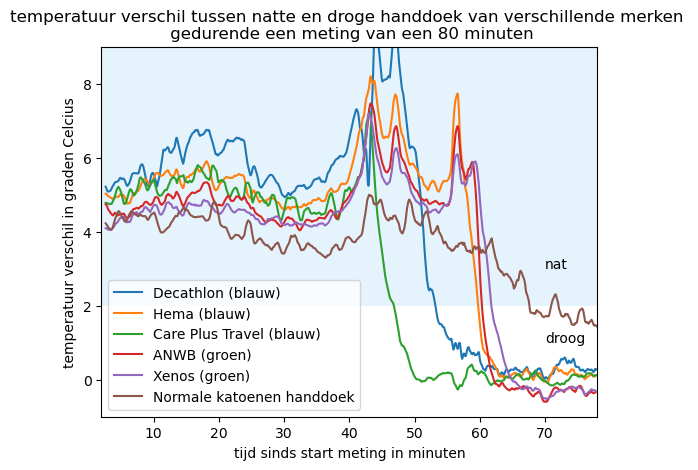

In [31]:

#maak een figuur met de resultaten en een legenda
tempAllTowelsFiltered.plot(
    y=list(handdoekenMeta.keys())).legend(list(handdoekenMeta.values()),
                                          loc = 'lower left')



plt.xlabel('tijd sinds start meting in minuten')
plt.ylabel('temperatuur verschil in graden Celcius')
plt.title('temperatuur verschil tussen natte en droge handdoek van verschillende merken \n gedurende een meting van een 80 minuten')
plt.ylim(-1,9)
plt.xlim(2,78)

rect = patches.Rectangle([2 , 2], 78, 7, linewidth=1, edgecolor='none', facecolor='#E5F3FD')
ax = plt.gca()
ax.add_patch(rect)
plt.text(70,3,"nat")
plt.text(70,1,"droog")

plt.savefig('figures/meting1/Handdoektestmeeting1.png',dpi = 300)

De resultaten laten duidelijk zien dat de Care Plus handdoek het snelste droogt. Dat blijkt ook uit de andere experimenten: in drie van de vier was de Care Plus handdoek de snelst droogende. In één van de vier experimenten was de Care Plus handdoek net iets langzamer dan de Decathlon handdoek.

Voor de uitzending van Kassa heb ik ook nog een bewegende gif gemaakt die bovenstaande grafiek langzaam opbouwd. Dat is niet te doen in een jupyter notebook, maar ik kan hem wel afbeelden, zie hieronder:

![SegmentLocal](figures/meting1/meeting1Movie.gif "bewegende gif van meetresultaten")

De code om deze gif te maken staat in het bestand ```resultatenNaarGif.py``` 